<a href="https://colab.research.google.com/github/gballos/IEEE-NTUA-SB-CS-Chapter-ML-Team/blob/main/IEEE_NTUA_SB_%7C_ML_Team_%7C_RL_w_CartPole_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import shutil

shutil.rmtree('/content/output')

FileNotFoundError: [Errno 2] No such file or directory: '/content/output'

In [ ]:
!mkdir output

In [ ]:
pip install renderlab gymnasium moviepy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 5.7 MB/s eta 0:00:00


In [ ]:
!pip install renderlab --upgrade


In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
from tqdm import tqdm
import renderlab as rl
import matplotlib
import matplotlib.pyplot as plt
import math
from IPython import display
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

  if event.key is 'enter':



In [ ]:
# Create the CartPole environment
env = gym.make('CartPole-v1') #render mode
# Initialize the renderer
#env = rl.RenderFrame(env, directory = "./output")

In [ ]:
# Neural network model for approximating Q-values
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.l3 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        return self.fc5(x)

In [ ]:
# Hyperparameters
learning_rate = 0.0001
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 1000
batch_size = 128
tau = 0.005
memory_size = 10000
episodes = 800

# Early stopping parameters
delta = 20  # Maximum allowed variation in episode durations
patience = 150  # Number of consecutive episodes with small variation before stopping


In [ ]:
# Initialize Q-networks
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
policy_net = DQN(input_dim, output_dim)
target_net = DQN(input_dim, output_dim)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
memory = deque(maxlen=memory_size)

In [ ]:
# Function to choose action using epsilon-greedy policy
def select_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()  # Explore
    else:
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = policy_net(state)
        return torch.argmax(q_values).item()  # Exploit

episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
      if not show_result:
          display.display(plt.gcf())
          display.clear_output(wait=True)
      else:
          display.display(plt.gcf())

In [ ]:
# Function to optimize the model using experience replay
def optimize_model():
    if len(memory) < batch_size:
        return

    batch = random.sample(memory, batch_size)
    state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)

    state_batch = torch.FloatTensor(state_batch)
    action_batch = torch.LongTensor(action_batch).unsqueeze(1)
    reward_batch = torch.FloatTensor(reward_batch)
    next_state_batch = torch.FloatTensor(next_state_batch)
    done_batch = torch.FloatTensor(done_batch)

    # Compute Q-values for current states
    q_values = policy_net(state_batch).gather(1, action_batch).squeeze()

    # Compute target Q-values using the target network
    with torch.no_grad():
        max_next_q_values = target_net(next_state_batch).max(1)[0]
        target_q_values = reward_batch + gamma * max_next_q_values * (1 - done_batch)

    criterion = nn.SmoothL1Loss()
    loss = criterion(q_values, target_q_values.detach())

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [ ]:
# Main training loop
rewards_per_episode = []
steps_done = 0

best_duration = 0  # Initialize best duration
patience_counter = 0  # Initialize patience counter

for episode in tqdm(range(episodes)):
    state, _ = env.reset()
    episode_reward = 0
    done = False
    t=0

    while not done:
        t += 1
        # Select action
        action = select_action(state, epsilon)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        # **Custom reward function**
        reward = 1.0  # Base reward

        # Penalize large cart deviations from the center
        x_th1, x_th2 = 0.25, 0.75  # Cart position threshold
        if abs(state[0]) > x_th1:
          reward -= 0.1
        if abs(state[0]) > x_th2:
          reward -= 0.5

        # Penalize large pole angle deviations
        theta_threshold_radians = 8 * 2 * np.pi / 360  # 8 degrees in radians
        if abs(state[2]) > theta_threshold_radians:
          reward -= 0.3

        # Reward staying upright for a longer time
        if not done:
          reward += 0.01 # small bonus for each step the pole is upright

        # Store transition in memory
        memory.append((state, action, reward, next_state, done))

        # Update state
        state = next_state

        episode_reward += reward

        # Optimize model
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*tau + target_net_state_dict[key]*(1-tau)
        target_net.load_state_dict(target_net_state_dict)

        steps_done += 1
        if done:
          episode_durations.append(t + 1)
          plot_durations()

          # Check for early stopping
          current_duration = t + 1
          if current_duration > best_duration + delta:
            best_duration = current_duration
            patience_counter = 0  # Reset patience counter
          else:
            patience_counter += 1

    if patience_counter >= patience:
      print(f"Early stopping at episode {episode} due to convergence.")
      break  # Terminate training


    # Decay epsilon
    epsilon = epsilon_min + (1.0 - epsilon_min) * math.exp(-1. * steps_done / epsilon_decay)

    rewards_per_episode.append(episode_reward)

    #if episode%100 == 0: #Play an episode to monitor training
    #  print(f"Epsiode: {episode}, Reward: {episode_reward}.")
    #  env.play()

 28%|██▊       | 222/800 [05:26<14:10,  1.47s/it]

Early stopping at episode 222 due to convergence.


<Figure size 640x480 with 0 Axes>

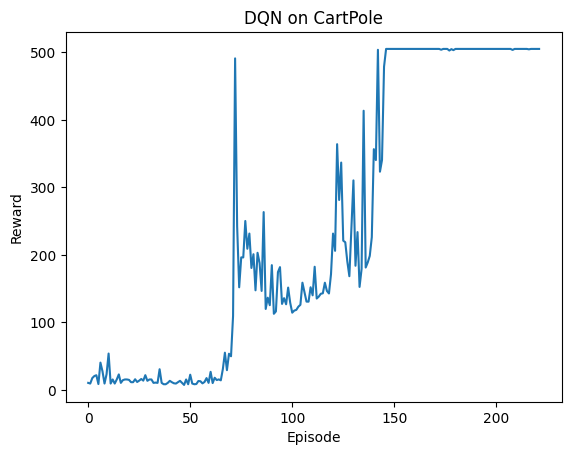

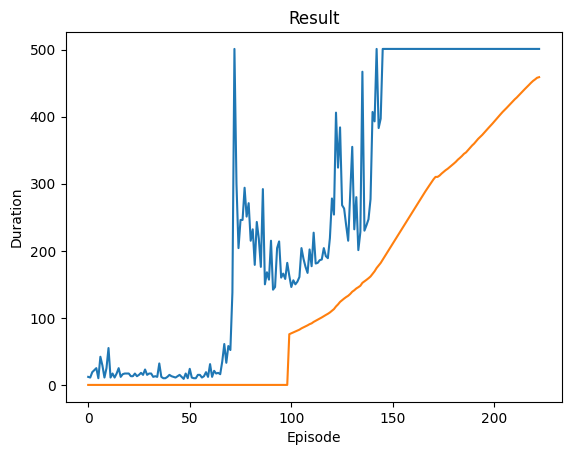

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
#Plotting reward per episode
plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DQN on CartPole')
plt.show()
#Plotting durations per episode
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [ ]:
env_test = gym.make('CartPole-v1', render_mode="rgb_array")
env_test = rl.RenderFrame(env_test, directory = "./output")
state, _ = env_test.reset()
done = False
while not done:
    action = select_action(state, 0) #will always use the DQN
    next_state, reward, terminated, truncated, _ = env_test.step(action)
    done = terminated or truncated
    state = next_state

if terminated:
  print("Terminated")
elif truncated:
  print("Truncated")
env_test.play()
env_test.close()

Truncated
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4
